In [94]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
%matplotlib inline

In [95]:
#파일 읽어오기
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [96]:
#train과 test의 feature를 set으로 저장
train_feats = train.columns
test_feats = test.columns

feats_onlyinTrain = []

for col in train_feats:
    if col not in test_feats:
        feats_onlyinTrain.append(col)        

In [97]:
#결측치 확인
train_feats_w_null = []
for col in train_feats:
    if train[col].isnull().sum() != 0:
        train_feats_w_null.append(col)

In [98]:
train_feats_w_null

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [99]:
#범주형 특성과 수치형 특성 나눔
numerical_feats = train.dtypes[train.dtypes !='object'].index
categorical_feats = train.dtypes[train.dtypes =='object'].index

각 특성과 SalePrice 사이의 상관관계 알아보기

In [100]:
#수치형 특성 
len(numerical_feats)

38

In [101]:
numerical_feats

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [102]:
#Id와 SalePrice를 제외한 36 가지 특성에 대해 확인 
numerical_feats = numerical_feats.drop(['Id', 'SalePrice'])

In [103]:
numerical_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [104]:
len(numerical_feats)

36

In [105]:
#for i in numerical_feats:
#    sns.scatterplot(data = train, x = i, y = 'SalePrice')
#    plt.show()

In [106]:
selected_numerical_feats = ['LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt','TotalBsmtSF']
selected_categorical_feats =  ['MSZoning', 'Street', 'ExterQual', 'BsmtQual', 'PavedDrive']
selected_features = selected_numerical_feats + selected_categorical_feats

## 결측치, 이상치 처리 

In [107]:
#추린 특성 중 결측치가 있는 것 
for col in train_feats_w_null:
    if (col in selected_numerical_feats) or (col in selected_categorical_feats):
        print(col)

LotFrontage
BsmtQual


In [108]:
#위 특성에 대해 결측치 처리

#LotFrontage: 수치형 변수, 평균값으로 채움
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].mean())

#BsmtQual,GarageType, PoolQC: 범주형 변수, 최빈값으로 채움
train['BsmtQual'] = train['BsmtQual'].fillna(train['BsmtQual'].mode()[0])

In [132]:
#테스트 셋 
#LotFrontage: 수치형 변수, 평균값으로 채움
test['LotFrontage'] = test['LotFrontage'].fillna(test['LotFrontage'].mean())
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(test['TotalBsmtSF'].mean()) ##test 셋에만 결측치가 있음 


#BsmtQual,GarageType, PoolQC: 범주형 변수, 최빈값으로 채움
test['BsmtQual'] = test['BsmtQual'].fillna(test['BsmtQual'].mode()[0])

In [110]:
#수치형 항목에 대해서 이상치 처리 
from collections import Counter

def outlier_detect(data, n, features):
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(data[col], 25)
        Q3 = np.percentile(data[col], 75)
        outlier_step = 1.5*(Q3 - Q1) 
        
        outlier_list_col = data[(data[col] < Q1-outlier_step) | (data[col] > Q3+outlier_step)].index
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outliers#위 특성에 대해 결측치 처리

In [111]:
outliers_to_drop = outlier_detect(train, 2, selected_numerical_feats)
len(outliers_to_drop)

6

In [112]:
train.shape

(1460, 81)

In [113]:
#inplace = True 옵션은 메모리 누수의 문제점이 있음
train = train.drop(outliers_to_drop, axis = 0)
train.shape

(1454, 81)

### 분포 확인

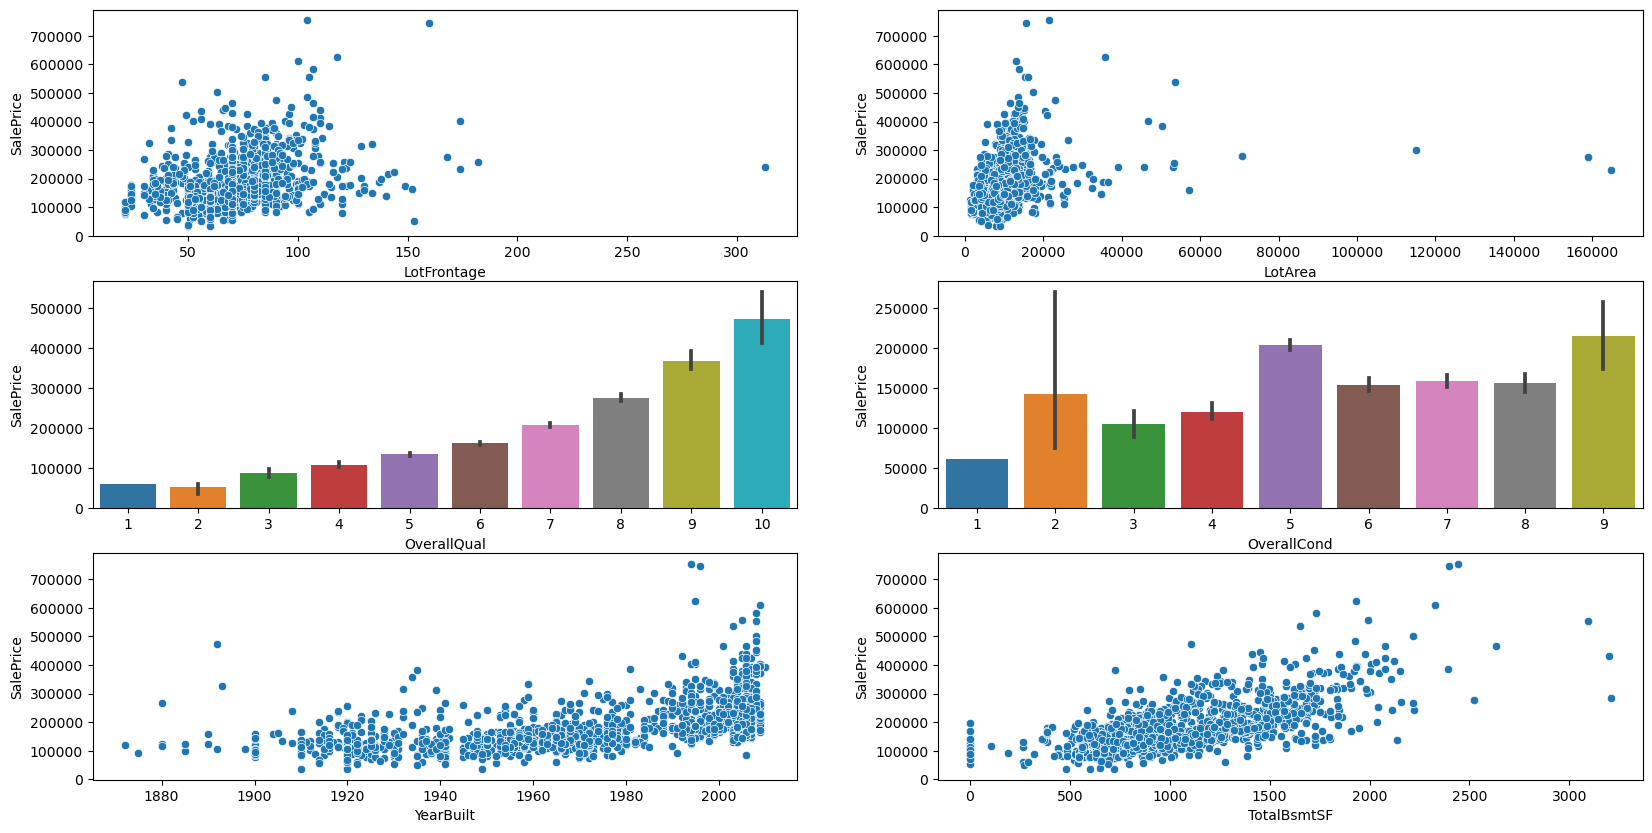

In [114]:
#수치형 변수 
f, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 10))
sns.scatterplot(data = train, x = 'LotFrontage', y = 'SalePrice', ax = axs[0][0])
sns.scatterplot(data = train, x = 'LotArea', y = 'SalePrice', ax = axs[0][1])
sns.barplot(data = train, x = 'OverallQual', y = 'SalePrice', ax = axs[1][0])
sns.barplot(data = train, x = 'OverallCond', y = 'SalePrice', ax = axs[1][1])
sns.scatterplot(data = train, x = 'YearBuilt', y = 'SalePrice', ax = axs[2][0])
sns.scatterplot(data = train, x = 'TotalBsmtSF', y = 'SalePrice', ax = axs[2][1])
plt.show()

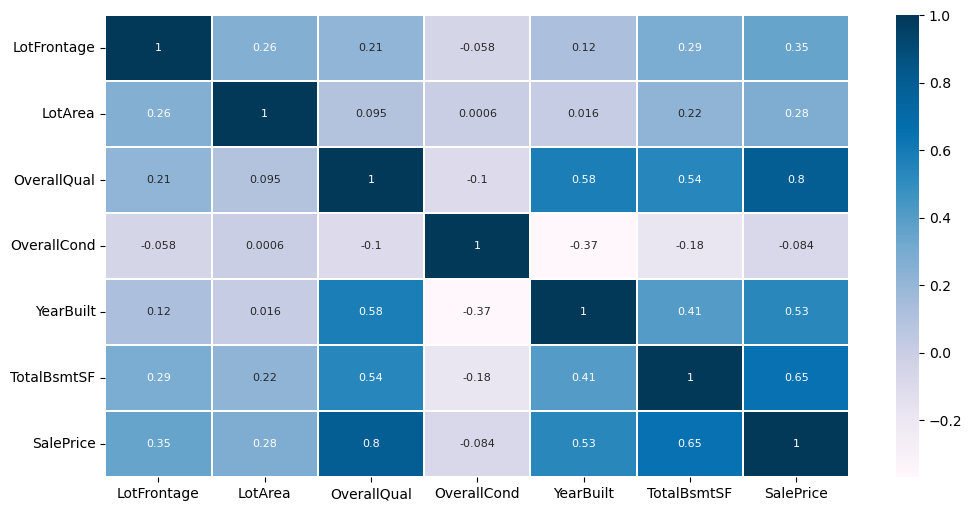

In [115]:
#수치형 데이터 상관계수 확인 
selected_numerical_feats.append('SalePrice') #SalePrice와의 상관관계 확인을 위해 추가 
corr_data = train[selected_numerical_feats]
colormap = plt.cm.PuBu

f, ax = plt.subplots(figsize = (12, 6))
sns.heatmap(corr_data.corr(), cmap=colormap, linewidth = 0.3, annot = True, annot_kws = {'size' : 8})
plt.show()

- OvercallCond를 제외하고는 양의 상관관계, 특히 OverallQual, YearBuilt, TotalBsmtSF 와 강한 양의 상관관계

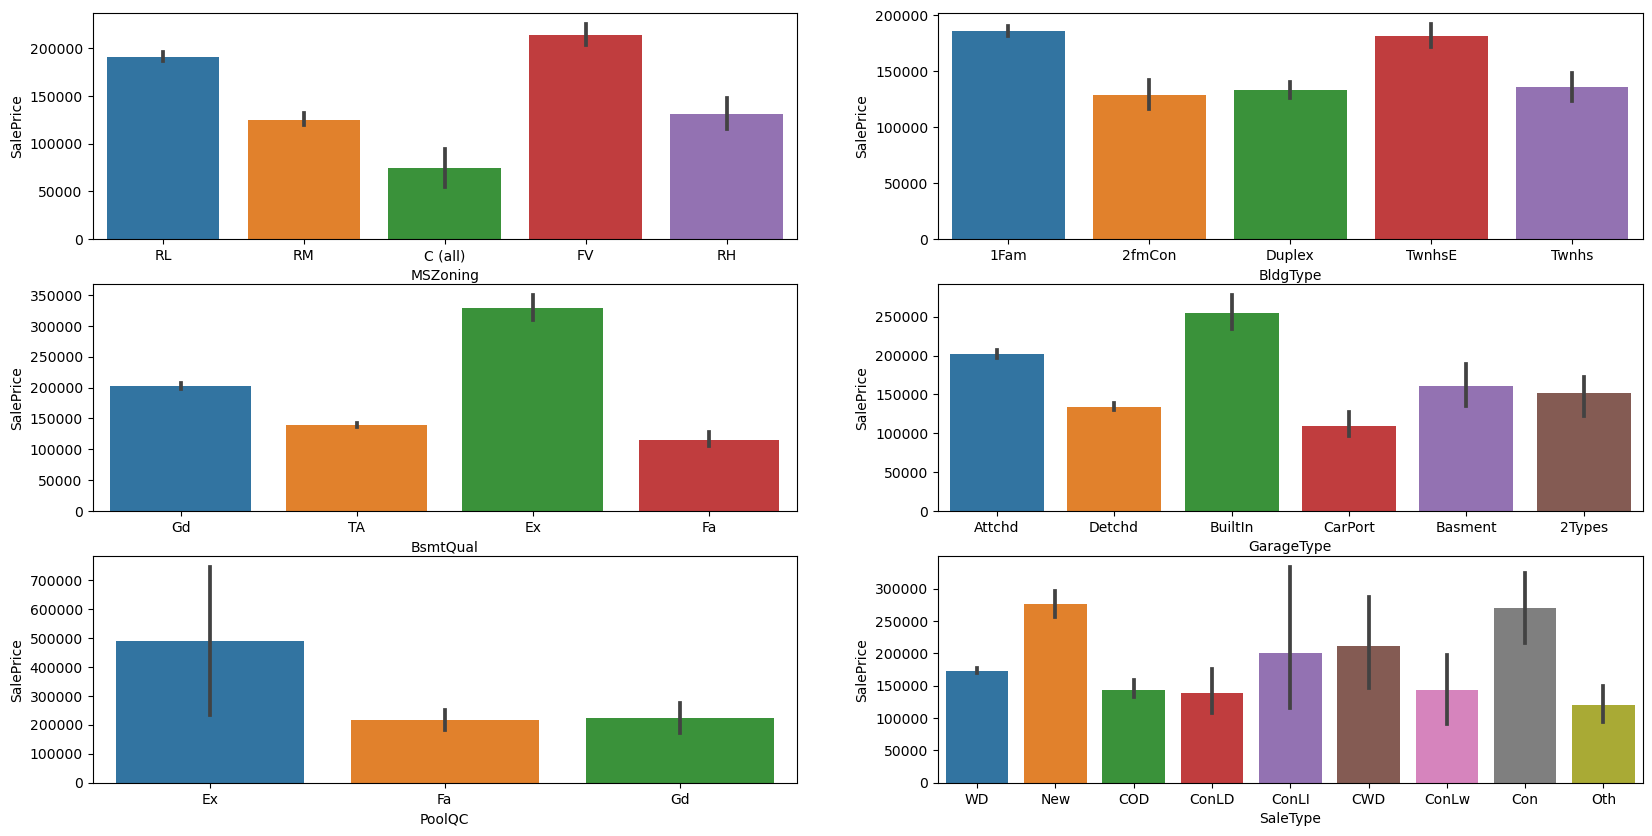

In [116]:
#범주형 변수 
f, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 10))
sns.barplot(data = train, x = 'MSZoning', y = 'SalePrice', ax = axs[0][0])
sns.barplot(data = train, x = 'BldgType', y = 'SalePrice', ax = axs[0][1])
sns.barplot(data = train, x = 'BsmtQual', y = 'SalePrice', ax = axs[1][0])
sns.barplot(data = train, x = 'GarageType', y = 'SalePrice', ax = axs[1][1])
sns.barplot(data = train, x = 'PoolQC', y = 'SalePrice', ax = axs[2][0])
sns.barplot(data = train, x = 'SaleType', y = 'SalePrice', ax = axs[2][1])
plt.show()

In [117]:
for col in selected_numerical_feats:
    print(
          '{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(train[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(train[col].kurt())  
         )

LotFrontage     Skewness: 01.70     Kurtosis: 014.99
LotArea         Skewness: 10.93     Kurtosis: 176.17
OverallQual     Skewness: 00.24     Kurtosis: 000.00
OverallCond     Skewness: 00.68     Kurtosis: 001.09
YearBuilt       Skewness: -0.60     Kurtosis: -00.48
TotalBsmtSF     Skewness: 00.52     Kurtosis: 001.79
SalePrice       Skewness: 01.90     Kurtosis: 006.62


In [123]:
#선택된 특성들만을 포함한 데이터 셋을 뽑자 
train_partial = train[selected_features]
#train_partial = pd.concat([train_partial, train['SalePrice']], axis = 1)
test_partial = test[selected_features]

### 범주형 변수 처리
- 숫자의 차이가 모델에 영향을 미치는 선형 계열 모델(로지스틱회귀, SVM, 신경망)에서는 라벨 인코딩보다 원-핫 인코딩 사용

In [124]:
#원=핫 인코딩 사용
for col in selected_categorical_feats:
    train_partial = pd.get_dummies(train_partial, columns = [col], prefix = col)

In [125]:
train_partial.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,TotalBsmtSF,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,...,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y
0,65.0,8450,7,5,2003,856,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
1,80.0,9600,6,8,1976,1262,0,0,0,1,...,0,0,1,0,0,1,0,0,0,1
2,68.0,11250,7,5,2001,920,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
3,60.0,9550,7,5,1915,756,0,0,0,1,...,0,0,1,0,0,0,1,0,0,1
4,84.0,14260,8,5,2000,1145,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1


In [90]:
train_partial.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,TotalBsmtSF,MSZoning,Street,ExterQual,BsmtQual,PavedDrive,SalePrice
0,65.0,8450,7,5,2003,856,RL,Pave,Gd,Gd,Y,208500
1,80.0,9600,6,8,1976,1262,RL,Pave,TA,Gd,Y,181500
2,68.0,11250,7,5,2001,920,RL,Pave,Gd,Gd,Y,223500
3,60.0,9550,7,5,1915,756,RL,Pave,TA,TA,Y,140000
4,84.0,14260,8,5,2000,1145,RL,Pave,Gd,Gd,Y,250000


In [128]:
#원=핫 인코딩 사용
for col in selected_categorical_feats:
    test_partial = pd.get_dummies(test_partial, columns = [col], prefix = col)

In [129]:
test_partial.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,TotalBsmtSF,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,...,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y
0,80.0,11622,5,6,1961,882.0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,1
1,81.0,14267,6,6,1958,1329.0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,1
2,74.0,13830,5,5,1997,928.0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,1
3,78.0,9978,6,6,1998,926.0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,1
4,43.0,5005,8,5,1992,1280.0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1


In [141]:
#결측치 확인
for col in test_partial.columns:
    if test_partial[col].isnull().sum() != 0:
        print(col)

TotalBsmtSF


### 로지스틱 회귀 

In [145]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train = train_partial.values
target_label = train['SalePrice'].values
X_test = test_partial.values

X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size = 0.2, random_state = 2000)

In [146]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_tr, y_tr)
lin_reg.intercept_, lin_reg.coef_

(-265805.643226282,
 array([ 3.36413187e+02,  1.49826124e+00,  2.34086966e+04,  4.76456450e+03,
         9.58358130e+01,  3.39842787e+01, -8.71602288e+03,  7.13132290e+03,
         1.44675646e+02,  6.72343198e+03, -5.28340765e+03, -3.08523540e+04,
         3.08523540e+04,  3.50612896e+04, -6.93089843e+03, -5.16323474e+03,
        -2.29671565e+04,  3.60567679e+04, -1.27984505e+04, -6.61094451e+03,
        -1.66473728e+04, -8.61627130e+02,  4.01006513e+02,  4.60620617e+02]))

In [149]:
lin_reg.score(X_tr, y_tr)

0.7995971060471486

In [148]:
lin_reg.score(X_vld, y_vld)

0.7497499377710557

In [183]:
#SGD 이용 
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
clf.fit(X_tr, y_tr)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

In [184]:
clf.score(X_tr, y_tr)

0.7994048728683758

In [185]:
clf.score(X_vld, y_vld)

0.7488053663782965

In [159]:
#다항회귀
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly_features.fit_transform(X_tr)

In [160]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y_tr)

LinearRegression()

In [163]:
lin_reg.score(X_poly, y_tr)

0.8526520325992669

In [164]:
X_vld_poly = poly_features.fit_transform(X_vld)
lin_reg.score(X_vld_poly, y_vld)

-6126.143682638341

## SVM 

In [165]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon = 1.5)
svm_reg.fit(X_tr, y_tr)

C:\Users\Nayoung\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR(epsilon=1.5)

In [168]:
svm_reg.score(X_vld, y_vld)

0.2274762883924416

In [169]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel = 'poly', degree = 2, C = 100, epsilon = 0.1)
svm_poly_reg.fit(X_tr, y_tr)

SVR(C=100, degree=2, kernel='poly')

In [171]:
svm_poly_reg.score(X_tr, y_tr)

-0.03851489311946499

In [170]:
svm_poly_reg.score(X_vld, y_vld)

-0.015410784089328056

## 결정트리

In [173]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth = 2)
tree_reg.fit(X_tr, y_tr)

DecisionTreeRegressor(max_depth=2)

In [174]:
tree_reg.score(X_tr, y_tr)

0.6629059883980748

In [176]:
tree_reg.score(X_vld, y_vld)

0.5957889292929508

## 그레디언트 트리 부스팅 

In [180]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 3, learning_rate = 1.0)
gbrt.fit(X_tr, y_tr)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [181]:
gbrt.score(X_tr, y_tr)

0.7617406134589464

In [182]:
gbrt.score(X_vld, y_vld)

0.7439052963206618